## Cross-Entropy/Self-Cross entropy benchmarking

Related paper [Andersen et al, arxiv:2405.17385](https://arxiv.org/abs/2405.17385) (And references therein)



In [2]:
using Revise
using ITensors
using ProgressMeter
using RandomMeas

We first consider a random circuit wavefunction $\psi$ of depth $d=2 steps$, by successive application of depth 2 random circuits. 

In order to simulate the corresponding experimental state in presence of noise, we consider the local depolarization channel to form a mixed state $\rho$

In [29]:

N = 8
steps = 20
ξ = siteinds("Qubit", N)
states = ["Dn" for n in 1:N]
cutoff = 1e-4
ψ0 = MPS(ξ,states);
ρ0 = outer(ψ0',ψ0);
p = 0.05*rand(N)
ψ = Vector{MPS}()
ρ = Vector{MPO}()
@showprogress dt=1 for d in 1:steps
        circuit_layer  = RandomCircuit(ξ,2)
        if d==1
            push!(ψ,apply(circuit_layer,ψ0;cutoff=cutoff))
            ρt = apply(circuit_layer,ρ0,apply_dag=true;cutoff=cutoff)
            ρt = Apply_depo_channel(ρt,p)
            push!(ρ,ρt);
        else
            push!(ψ,apply(circuit_layer,ψ[d-1];cutoff=cutoff))
            ρt = apply(circuit_layer,ρ[d-1],apply_dag=true;cutoff=cutoff)
            ρt = Apply_depo_channel(ρt,p)
            push!(ρ,ρt);  
        end
end

println("State prepared")
println("with bond dimension (pure state) ", maxlinkdim(ψ[steps]))
println("with bond dimension (mixed state) ", maxlinkdim(ρ[steps]))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


State prepared
with bond dimension (pure state) 16
with bond dimension (mixed state) 231


In [30]:
#Perform Randomized measurements
NM= 1000
XEB = zeros(Float64,steps)
selfXEB = zeros(Float64,steps)
XEB_c = zeros(Float64,steps)

data = zeros(Int8,(NM,N))
F = [real(inner(ψ[d]',ρ[d],ψ[d])) for d in 1:steps];

u = get_rotations(ξ,6)

@showprogress dt=1 for d in 1:steps
    P0 = get_Born_MPS(ψ[d])
    truncate!(P0;cutoff=cutoff)
    orthogonalize!(ρ[d],1)
    data = get_RandomMeas(ρ[d],u,NM)
    for m in 1:NM
        V = ITensor(1.)
        for j=1:N
              V *= (P0[j]*state(ξ[j],data[m,j]))
        end
        XEB[d] += 2^N/NM*real(V[])-1/NM
    end

    selfXEB[d] = 2^N*real(inner(P0,P0))-1
    XEB_c[d] = XEB[d]/selfXEB[d]
end

     


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


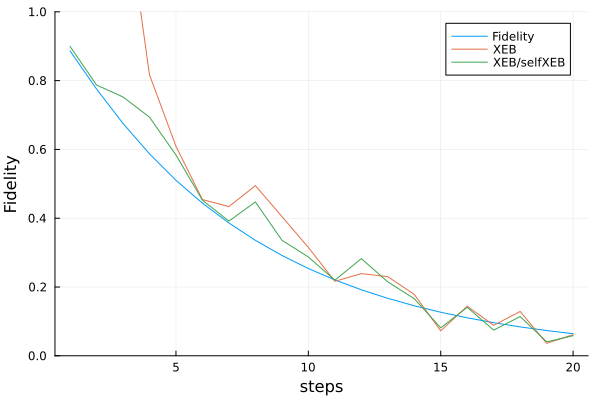

In [38]:
using Plots
plot(1:steps,F,label="Fidelity")
plot!(1:steps,XEB,label="XEB")
plot!(1:steps,XEB_c,label="XEB/selfXEB")
xlabel!("steps")
ylabel!("Fidelity")
ylims!((0,1))